In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [792]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
from rpy2.robjects.packages import importr
from rpy2.robjects import globalenv
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [213]:
%load_ext autoreload
%autoreload 2

In [412]:
splatter = importr("splatter")
base = importr("base")
scuttle = importr("scuttle")
BiocSingular = importr("BiocSingular")
BiocGenerics = importr("BiocGenerics")
igraph = importr("igraph")
TSP = importr("TSP")
stats = importr("stats")

In [5]:
rpy2.robjects.numpy2ri.deactivate()
num_cells = 500
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 1000)
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", num_cells),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
#sim1 = BiocSingular.runPCA(sim1, ntop=num_cells, ncomponents=num_cells/10)
rpy2.robjects.numpy2ri.activate()

In [23]:
list(sim1.slots)

['int_metadata',
 'int_elementMetadata',
 'int_colData',
 'rowRanges',
 'colData',
 'assays',
 'NAMES',
 'elementMetadata',
 'metadata',
 'class']

In [101]:
class REXPR():
    def __init__(self, r_object):
        self.r_object = r_object
        
    def __getitem__(self, idxs: (tuple, str)):
        if isinstance(idxs, str):
            # If just passed a single index, don't
            # split it up in characters!
            return REXPR(self.r_object.slots[idxs])
        # Recursively iterate over every index
        temp = self.r_object
        for idx in idxs:
            temp = temp.slots[idx]
        return REXPR(temp)
    
    @property
    def slots(self):
        return list(self.r_object.slots)
    
    def __repr__(self):
        return f"[REXPR]: {repr(self.r_object)}"
    
    def __getattr__(self, attrname):
        return base.__dict__["$"](self.r_object, attrname)

In [353]:
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
# Idx 0: Genes, Idx 1: Cells
print(log_counts.shape)

(1000, 500)


In [354]:
from sklearn.decomposition import PCA

In [536]:
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)
print(pcad_vals.shape)

(500, 2)


In [537]:
true_first_cell = np.array(sc_data['colData'].Step).argmin()
true_last_cell = np.array(sc_data['colData'].Step).argmax()
print(true_first_cell)
print(true_last_cell)

66
6


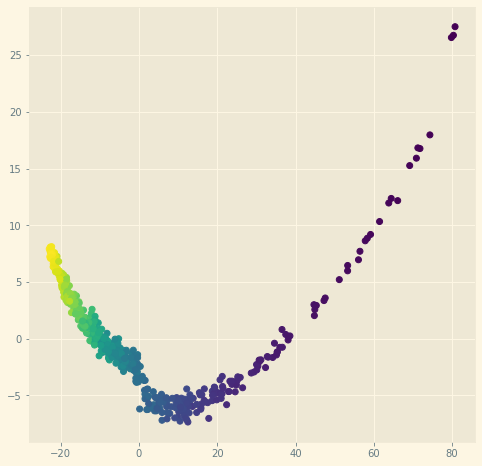

In [357]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*pcad_vals.T, c=np.array(sc_data['colData'].Step))

In [178]:
from Scripts.utilities import reconstruct_axes, binarize_matrix
from Scripts.antGLasso import antGLasso_heuristic
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic

# Naive Method

In [582]:
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((log_counts+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering

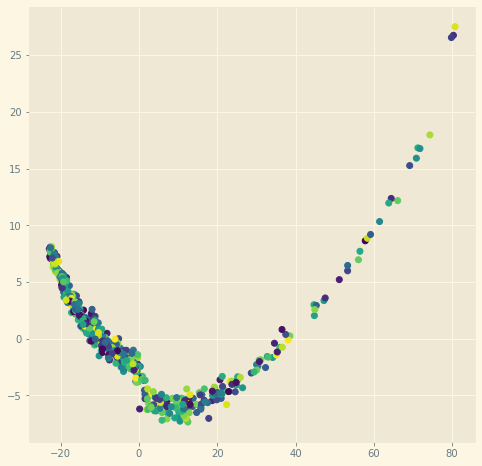

In [587]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    new_pca = PCA(n_components=2).fit_transform(unmixed.T).T
    ax.scatter(*new_pca, c=colors)

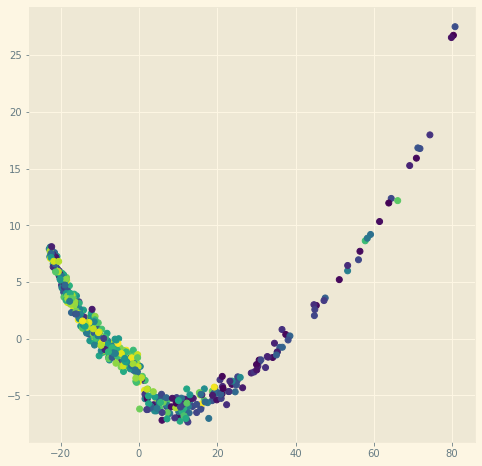

In [440]:
# This is just coloring them by the magnitude of the first
# gene in each cell!  Such a simple method
# is able to do much better than the sophisticated antGLasso.
unmixed_test = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis
)[0]
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.argsort(np.argsort(unmixed_test[0]))
    ax.scatter(*pcad_vals.T, c=colors)

In [460]:
from scipy.sparse.csgraph import minimum_spanning_tree
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[1])).todense()).argmax(axis=1)

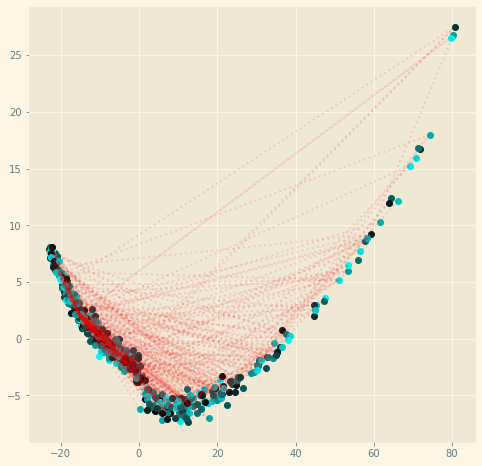

In [461]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

In [518]:
psi_as_graph = igraph.graph_from_adjacency_matrix(
    -np.abs(Psis[1]) + np.max(np.abs(Psis[1])),
    weighted=True,
    diag=False
)
# Add 1 b/c r starts from 1 not 0
TEST = igraph.graph_from_adjacency_matrix(
    (minimum_spanning_tree(-np.abs(Psis[1]) + np.max(np.abs(Psis[1]))).todense()),
    weighted=True,
    diag=False
)
print(TEST)
graph_ = REXPR(igraph.shortest_paths(
    igraph.as_undirected(TEST, mode="collapse"),
    true_first_cell + 1,
    true_last_cell + 1
)).vpath[0]
print(graph_)

IGRAPH 3965439 D-W- 500 499 -- 
+ attr: weight (e/n)
+ edges from 3965439:
 [1]  2->302  3->369  4->243  5->161  8->205  8->322  8->375  8->429 10->250
[10] 11->150 13->350 14->297 15->397 17-> 51 18->440 19->381 24-> 51 25-> 51
[19] 26->309 26->332 30-> 39 30->101 30->128 31->275 31->324 32->113 34-> 51
[28] 35->389 37->351 38->130 39->159 39->173 39->200 39->241 39->253 39->261
[37] 39->290 39->318 39->345 39->362 39->400 39->442 39->452 40->345 41-> 39
[46] 41->306 41->379 42-> 21 42->132 43-> 94 46->110 47-> 36 48->404 49->167
[55] 50->351 51->  1 51->  7 51->  9 51-> 16 51-> 54 51-> 77 51->124 51->151
[64] 51->184 51->199 51->217 51->218 51->254 51->297 51->302 51->305 51->324
+ ... omitted several edges

[ 67 132  51   7]


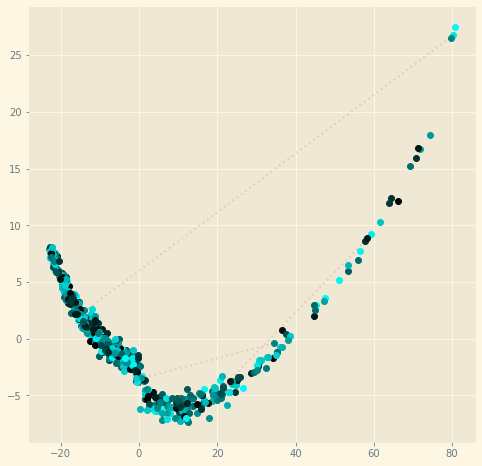

In [521]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        if idx >= len(graph_):
            break
        idx2 = graph_[idx]-1
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# Naive Method on PCA Values
Doesn't work - but that's fine b/c we don't really want to do this

In [538]:
noise = np.random.random(pcad_vals.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((pcad_vals+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis,
    return_order=True
)
unmixed = unmixed.squeeze()
order = order[0]

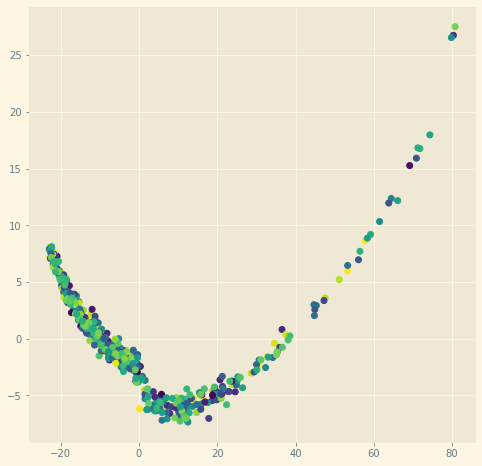

In [539]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    ax.scatter(*pcad_vals.T, c=colors)

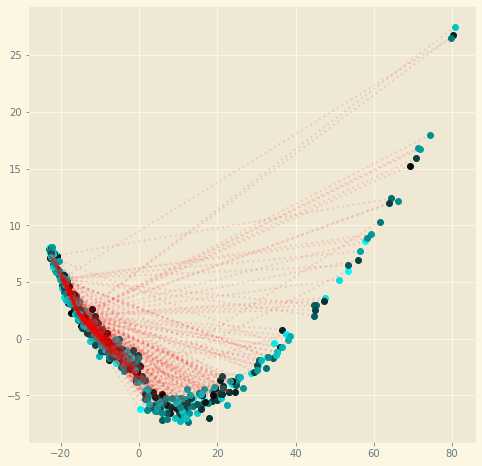

In [540]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# PCA the other way?

In [522]:
pcad_vals = PCA(n_components=2).fit_transform(log_counts)
print(pcad_vals.shape)

(1000, 2)


In [523]:
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((log_counts+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering

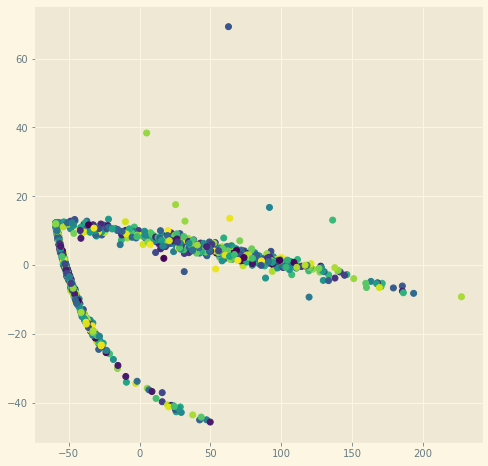

In [531]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    ax.scatter(*pcad_vals.T, c=colors)

In [534]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)

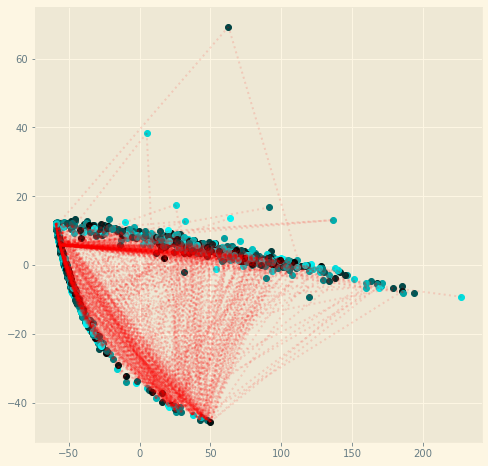

In [535]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# Fully synthetic data

In [786]:
xs = np.linspace(0., 1., 100).reshape(-1, 1)
ys = xs**2
data = np.concatenate([xs, ys], axis=1)[np.newaxis, ...]
data = data + np.random.random((1000, 100, 2)) / 1000
print(data.shape)

(1000, 100, 2)


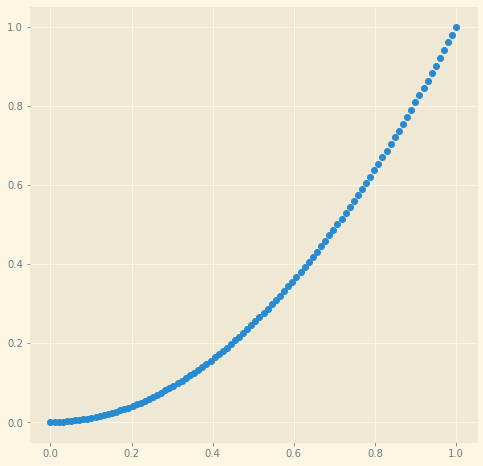

In [787]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data[0, :, 0], data[0, :, 1])

In [788]:
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic(data),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    data,
    [1],
    Psis=Psis,
    return_order=True,
    first_idx=0
)
order = order[0] # get ordering
print(unmixed[0, :10])

[[1.46444100e-04 4.89767137e-04]
 [1.00044091e+00 1.00070753e+00]
 [2.06919033e-02 1.12442743e-03]
 [5.15206770e-01 2.65894239e-01]
 [6.16983747e-01 3.80473690e-01]
 [3.34089122e-01 1.11990185e-01]
 [7.27487737e-01 5.29346412e-01]
 [6.26311469e-01 3.92266188e-01]
 [4.64656537e-01 2.16544021e-01]
 [6.56611022e-01 4.31805646e-01]]


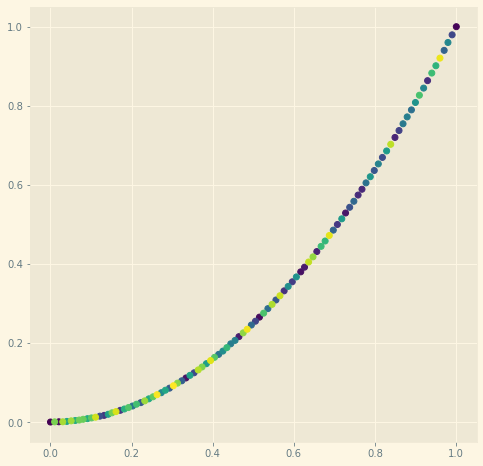

In [789]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*unmixed[0].T, c=range(0, unmixed.shape[1]))

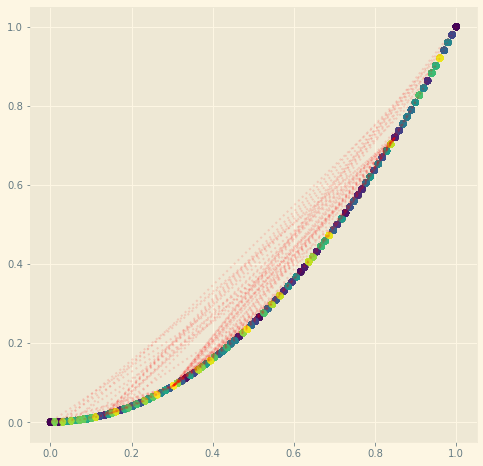

In [790]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(unmixed[0]):
        ax.scatter(*unmixed[0].T, c=range(0, unmixed.shape[1]))
    for idx, (x1, y1) in enumerate(unmixed[0]):
        idx2 = graph[idx]-1
        x2, y2 = unmixed[0, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# With more noise

In [759]:
samples = 10
noise1 = np.random.random((samples, 1, 500)) + 0.5
noise2 = np.random.random((samples, 1000, 1)) + 0.5
noise3 = np.random.random((samples, 1000, 500))
nonpara = nonparanormal_tensor_skeptic((log_counts*noise1*noise2+noise3/1000))

In [760]:
Psis = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
order = order[0]

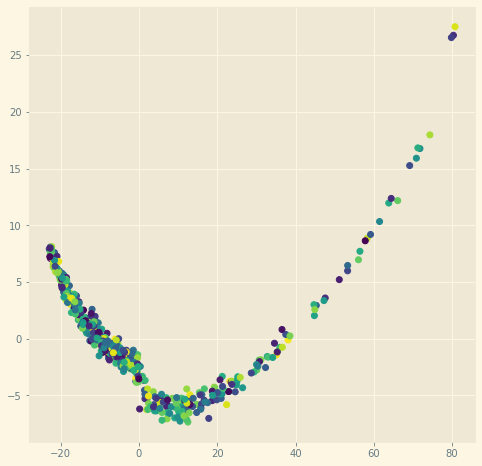

In [761]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)

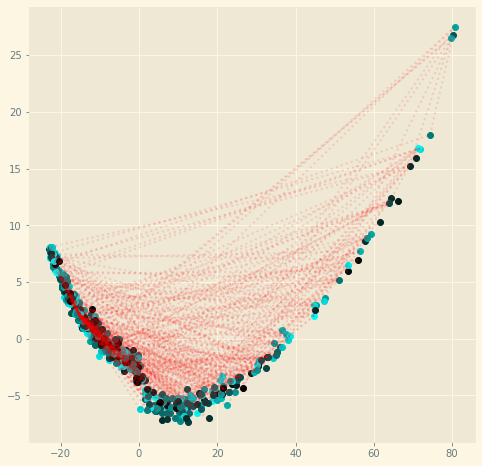

In [762]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[1])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# As a clustering alg

In [1277]:
rpy2.robjects.numpy2ri.deactivate()
num_cells = 200
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 10)
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", 2),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)
rpy2.robjects.numpy2ri.activate()

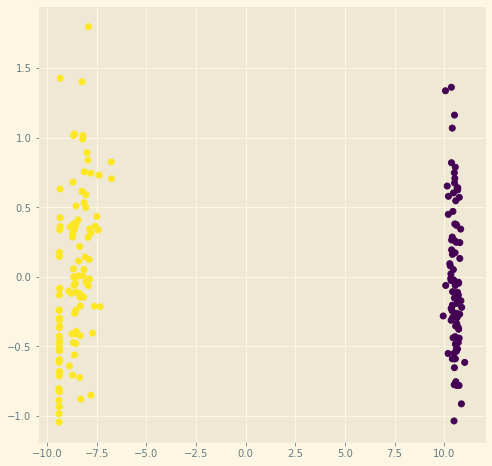

In [1278]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*pcad_vals.T, c=np.array(sc_data['colData'].Step))

In [1279]:
samples = 10
noise = np.random.random((samples, *log_counts.shape)) / 1000
nonpara = nonparanormal_tensor_skeptic((log_counts+noise))

In [ ]:
"""from Scripts.EiGLasso import EiGLasso
Psis = EiGLasso_cov(
    T = nonpara[0],
    S = nonpara[1],
    beta_1=0,
    beta_2=0,
    #B_approx_iters=1000
)""" # EiGLasso does similarly
Psis = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

In [ ]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[1])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    fig.savefig("../../Plots/Fundamental Barriers/EiGLasso Poor Clustering")
    #fig.savefig("../../Plots/Fundamental Barriers/antGLasso Poor Clustering")

# What if we directly generate data from KS distribution?
To see if it even makes sense to do what we're trying to do!

In [1270]:
from Scripts.generate_data import fast_matrix_normal_ks, \
    generate_sparse_posdef_matrix, \
    fast_tensor_normal_ks

In [1271]:
dimensions = np.array([[1, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples
).squeeze()
print(dimensions.shape)
print(samples.shape)
datapoints = fast_tensor_normal_ks([dimensions, samples], 1).squeeze()
print(datapoints.shape)

(2, 2)
(100, 100)
(2, 100)


In [1272]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(samples)).todense()).argmax(axis=1)

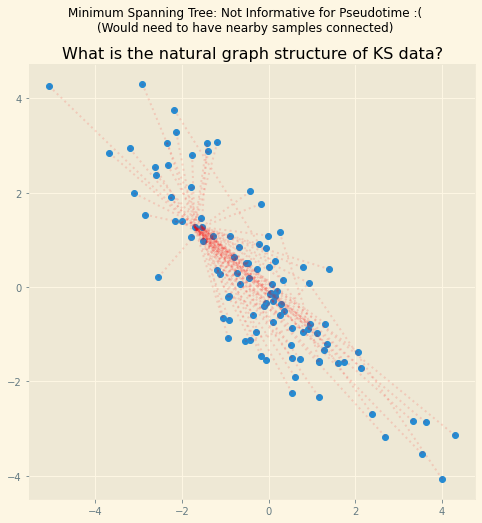

In [1274]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS MST.png")

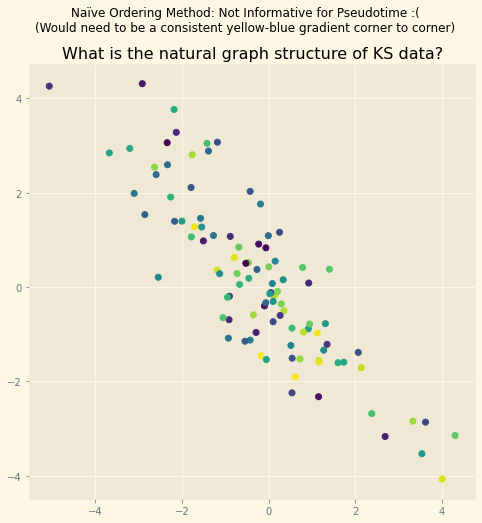

In [1275]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Naive.png")

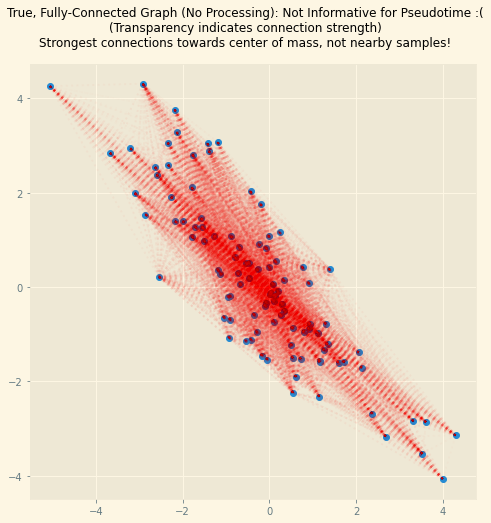

In [1276]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Full.png")

In [980]:
dimensions = np.array([[0.1, 0.9], [0.9, 1]])
num_samples = 100
samples = np.eye(num_samples)
rows, cols = np.indices((num_samples, num_samples))
samples[np.diag(rows, k=1), np.diag(cols, k=1)] = 0.01
samples[np.diag(rows, k=-1), np.diag(cols, k=-1)] = 0.01
datapoints = fast_tensor_normal_ks([dimensions, samples], 1).squeeze()

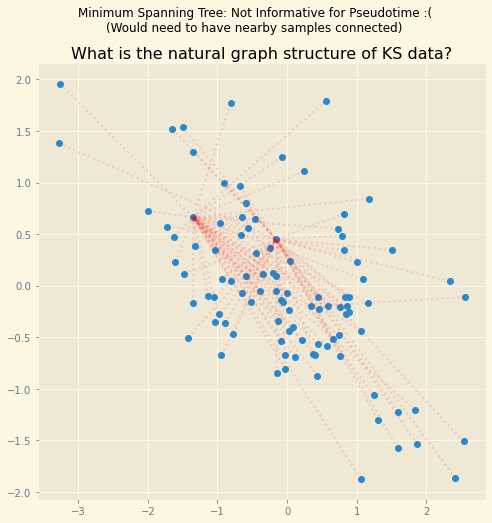

In [981]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS MST Tridiagonal.png")

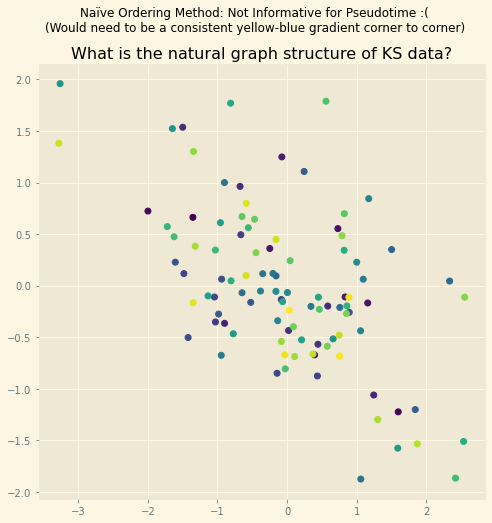

In [982]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Naive Tridiagonal.png")

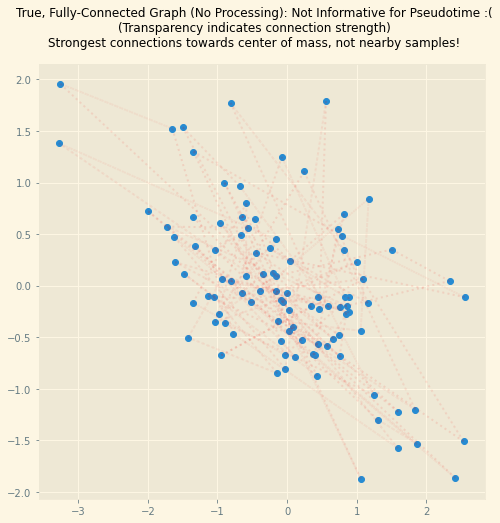

In [985]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Full Tridiagonal.png")

# Other Graph Products

In [1252]:
dimensions = np.array([[0.01, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples,
).squeeze()

In [1253]:
def get_graph_product_for_precisions(Psi, Theta, graph_product: list):
    nss, \
    nse, \
    nst, \
    nes, \
    nee, \
    net, \
    nts, \
    nte, \
    ntt = graph_product
    I_psi = np.eye(Psi.shape[0])
    J_psi = np.ones(Psi.shape)
    I_theta = np.eye(Theta.shape[0])
    J_theta = np.ones(Theta.shape)
    A = nss * Theta + nse * I_theta + nst * J_theta
    B = nes * Theta + nee * I_theta + net * J_theta
    C = nts * Theta + nte * I_theta + ntt * J_theta
    return np.kron(Psi, A) + np.kron(I_psi, B) + np.kron(J_psi, C)
    
precisions = get_graph_product_for_precisions(
    samples,
    dimensions,
    [-1, -1, 1, -1, -1, 1, 1, 1, 0]
)

In [1254]:
from scipy.stats import multivariate_normal
datapoints = multivariate_normal.rvs(cov=np.linalg.inv(precisions))
datapoints = datapoints.reshape(100, 2)

/Users/baileyandrew/opt/anaconda3/envs/my_default_environment/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


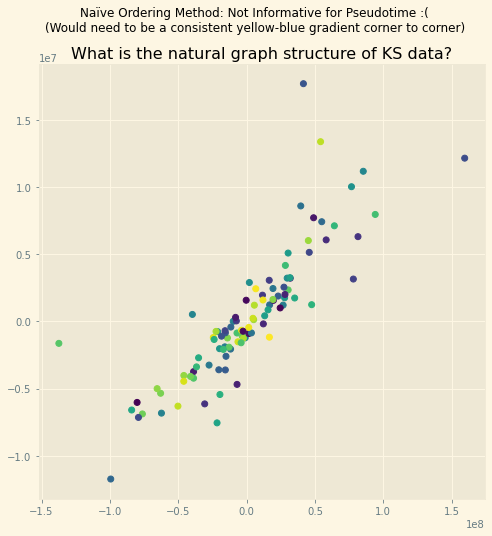

In [1255]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [1],
    Psis=[samples, dimensions],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints.T, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Naive Tridiagonal.png")

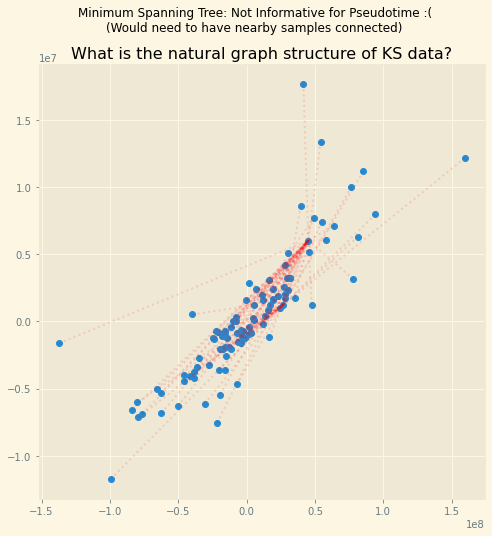

In [1256]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints.T)
    for idx, (x1, y1) in enumerate(datapoints):
        idx2 = graph[idx]
        x2, y2 = datapoints[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS MST Tridiagonal.png")

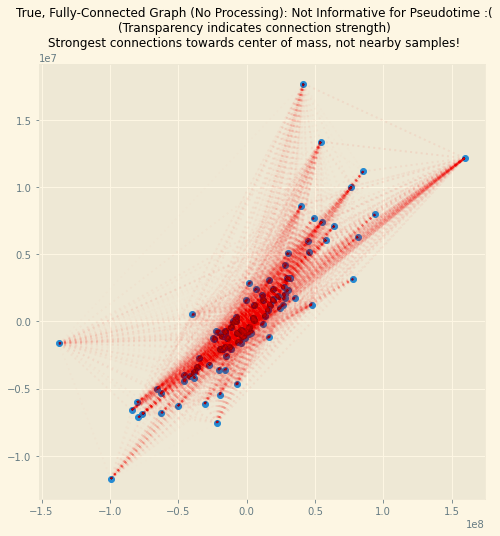

In [1257]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints.T)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )

# What if we had multiple samples?

In [1264]:
dimensions = np.array([[1, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples
).squeeze()
print(dimensions.shape)
print(samples.shape)
datapoints = fast_tensor_normal_ks([dimensions, samples], 1000)
print(datapoints.shape)
datapoints = datapoints.mean(axis=0)
datapoints.shape

(2, 2)
(100, 100)
(1000, 2, 100)


(2, 100)

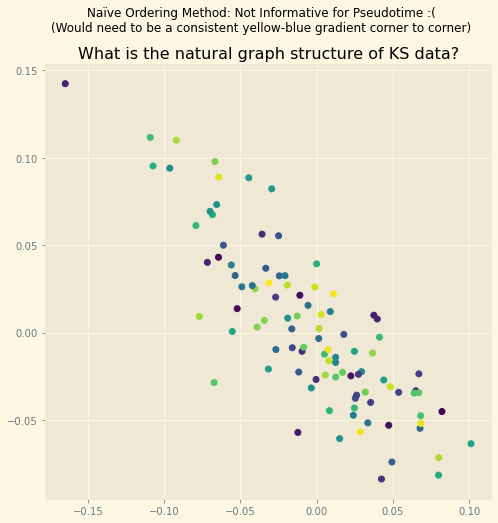

In [1267]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Naive.png")

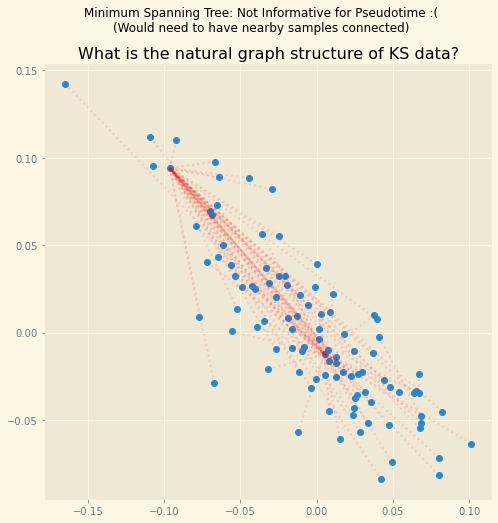

In [1269]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS MST.png")

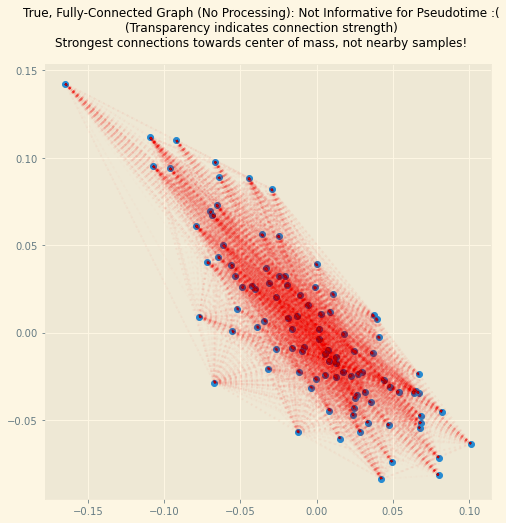

In [1268]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Full.png")